# Targeted Feature Detection
Use if Retention time is known (likely window can be defined)

In [1]:
# import methods from FIA python script   
from FIA import *
import os

## Library Preparation

In [3]:
# set path to your mzML files and workfolder
data_dir = "../data/example data/exampleA_ecolistrains"
run_dir = "../runs/example"

data_dir = os.path.normpath(os.path.join(os.getcwd(), data_dir))
run_dir = os.path.normpath(os.path.join(os.getcwd(), run_dir))

# clean_dir(run_dir)

In [3]:
# centroid_dir = centroid_batch(data_dir, run_dir, file_ending=".mzXML")
centroid_dir = os.path.join(run_dir, "centroids")

100%|██████████| 6/6 [01:33<00:00, 15.57s/it]


## Targeted

- mz_window: window in ppm
- rt_window: in seconds
- peak_widtth: expected elution peak in seconds
- n_isotopes: Number of isotopes to include in each assay

In [20]:
feature_maps = targeted_features_detection(centroid_dir, run_dir, file_ending=".mzML", compound_library_file="../databases/compounds_merged.tsv", 
                                           mz_window=10.0, rt_window=1000.0, n_isotopes=2, isotope_pmin=0.01,
                                           peak_width=6.0, mass_range=[50.0, 10000.0])

Defining metabolite table...
Read in 63419 metabolites.
24643 remaining after excluding zero charged metabolites.
Finished metabolite table.
Metabolite table defined...
RT window size calculated as 240 seconds.
Extracting chromatograms...
Detecting chromatographic peaks...
Found 114956 feature candidates in total.
23274 features left after selection of best candidates.
Model fitting: 3711 successes, 17140 failures
Imputing model failures with a linear model based on log(rawIntensities). Slope: 0.98711, Intercept: 0.301553
Feature map created.
RT window size calculated as 240 seconds.
Extracting chromatograms...
Detecting chromatographic peaks...
Found 116408 feature candidates in total.
23282 features left after selection of best candidates.
Model fitting: 3130 successes, 17490 failures
Imputing model failures with a linear model based on log(rawIntensities). Slope: 0.977158, Intercept: 0.444114
Feature map created.
RT window size calculated as 240 seconds.
Extracting chromatograms...


In [21]:
store_feature_maps(feature_maps, out_dir=os.path.join(run_dir, "features_targeted"), ending=".mzML")

Storing feature maps:


100%|██████████| 6/6 [01:20<00:00, 13.47s/it]


## Feature refinement

In [4]:
feature_maps = read_feature_maps_XML(os.path.join(run_dir, "features_targeted"))

Reading in feature maps:


100%|██████████| 6/6 [01:35<00:00, 15.97s/it]


In [5]:
feature_maps_pol = assign_feature_maps_polarity(feature_maps)

Assign polarity to feature maps:


100%|██████████| 6/6 [00:01<00:00,  5.30it/s]


In [6]:
feature_maps_pos, feature_maps_neg = separate_feature_maps_pos_neg(feature_maps=feature_maps_pol)

Separating feature maps:


100%|██████████| 6/6 [00:00<00:00, 722.60it/s]


### Unlabeled

Compute a zero-charge feature map from a set of charged features. 
Find putative ChargePairs, then score them and hand over to ILP.

In [7]:
feature_maps_pos_algn = align_retention_times(feature_maps_pos, 
                                                max_num_peaks_considered=-1,      # -1 -> consider infinite/all peaks
                                                max_mz_difference=5.0,
                                                mz_unit="ppm",
                                                superimposer_max_scaling=100.0)
store_feature_maps(feature_maps_pos_algn, "../runs/example/features_rtaligned", ".mzML")

feature_maps_neg_algn = align_retention_times(feature_maps_neg, 
                                                max_num_peaks_considered=-1,      # -1 -> consider infinite/all peaks
                                                max_mz_difference=5.0,
                                                mz_unit="ppm",
                                                superimposer_max_scaling=100.0)
store_feature_maps(feature_maps_neg_algn, "../runs/example/features_rtaligned", ".mzML")

Searching feature map with larges number of features:
Aligning retention times:


100%|██████████| 2/2 [00:18<00:00,  9.05s/it]


Storing feature maps:


100%|██████████| 3/3 [00:39<00:00, 13.05s/it]


Searching feature map with larges number of features:
Aligning retention times:


100%|██████████| 2/2 [00:17<00:00,  8.77s/it]


Storing feature maps:


100%|██████████| 3/3 [00:30<00:00, 10.21s/it]


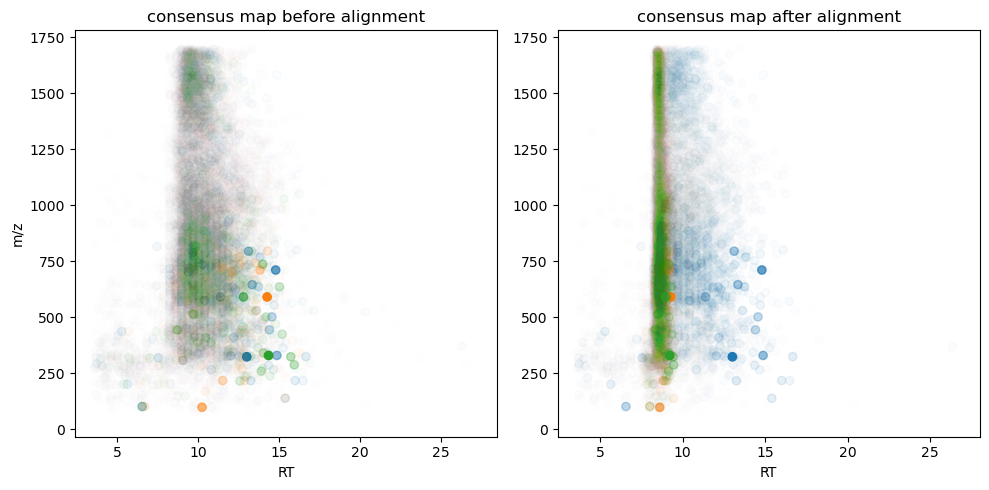

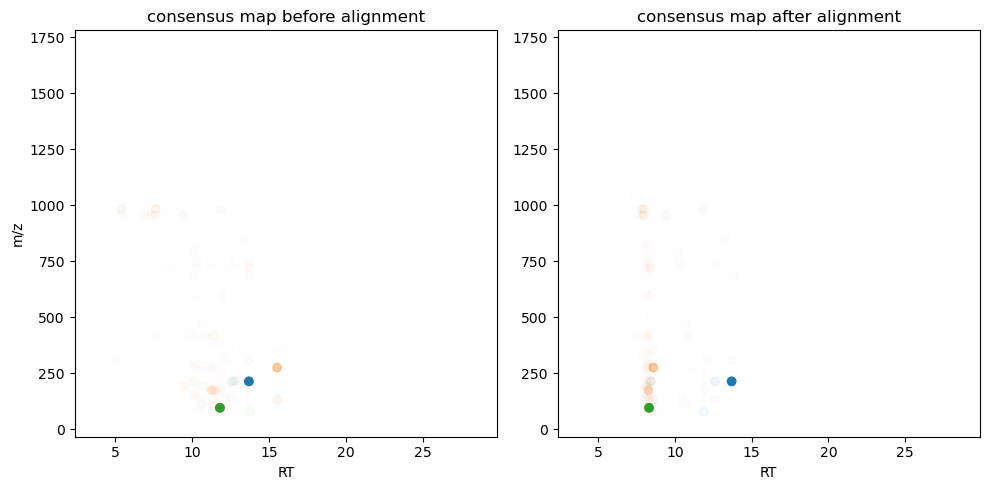

In [9]:
plot_feature_map_rt_alignment(feature_maps_pos_algn)
plot_feature_map_rt_alignment(feature_maps_neg_algn)

## Consensus building

In [10]:
consensus_map_pos = consensus_features_linking(feature_maps_pos, feature_grouper="QT")
consensus_map_pos = assign_feature_maps_polarity([consensus_map_pos], "positive")[0]
consensus_map_neg = consensus_features_linking(feature_maps_neg, feature_grouper="QT")
consensus_map_neg = assign_feature_maps_polarity([consensus_map_neg], "negative")[0]

Assign polarity to feature maps:
Progress of 'Linking features':
-- done [took 1.42 s (CPU), 1.41 s (Wall)] -- 


100%|██████████| 1/1 [00:00<00:00, 20.52it/s]


Progress of 'Linking features':
-- done [took 1.31 s (CPU), 1.31 s (Wall)] -- 
Assign polarity to feature maps:


100%|██████████| 1/1 [00:00<00:00, 26.13it/s]


In [11]:
cm_pos_df = consensus_map_to_df(consensus_map_pos)
filtered_cm_pos_df = filter_consensus_map_df(cm_pos_df, max_missing_values=1, min_feature_quality=sorted(cm_pos_df["quality"], reverse=True)[10000])
imputed_cm_pos_df = impute_consensus_map_df(filtered_cm_pos_df, n_nearest_neighbours=2)

cm_neg_df = consensus_map_to_df(consensus_map_neg)
filtered_cm_neg_df = filter_consensus_map_df(cm_neg_df, max_missing_values=1, min_feature_quality=sorted(cm_neg_df["quality"], reverse=True)[10000])
imputed_cm_neg_df = impute_consensus_map_df(filtered_cm_neg_df, n_nearest_neighbours=2)

In [12]:
sorted(cm_pos_df["quality"], reverse=True)[10000]

0.9942565560340881

In [13]:
imputed_cm_pos_df

RT           mz   quality  nissle_P3-H7_pos.mzML  \
0      8.052392   292.241324  0.998147           21078.689453   
1      9.367075   976.613074  0.994381           18785.880859   
2      9.035119   897.625854  0.995825           28911.990234   
3      7.924372   248.087404  0.996692            2472.585693   
4      9.008094  1571.732604  0.996391           68049.406250   
...         ...          ...       ...                    ...   
9996   8.180541   357.156526  0.996397            3631.209229   
9997   8.816035  1015.474617  0.997019           16071.339844   
9998   8.600310   839.904924  0.998412           17329.789062   
9999   8.693393  1185.965074  0.997760            2624.856201   
10000  7.505008   218.489789  0.995141             276.025696   

       tue1_P3-C6_pos.mzML  mg1655_P3-A8_pos.mzML  
0              4809.510742            7933.482910  
1             34123.210938           33172.328125  
2              2414.485352            7503.990723  
3              6380.551270            5589.706543  
4             42074.011719           26865.800781  
...                    ...                    ...  
9996           1273.262939            1114.658447  
9997           9979.599609           18425.960938  
9998           8048.597656            7944.536133  
9999           9130.870117            5849.719727  
10000            48.831768             319.153748  

[10001 rows x 6 columns]

## Labeling

In [14]:
mass_search_pos_df = accurate_mass_search(consensus_map_pos, "../databases/HMDB/", "../runs/exampleA/tmp",
 "PositiveAdducts.tsv", "NegativeAdducts.tsv", "HMDBMappingFile.tsv", "HMDB2StructMapping.tsv", ionization_mode="positive")
mass_search_neg_df = accurate_mass_search(consensus_map_neg, "../databases/HMDB/", "../runs/exampleA/tmp",
 "PositiveAdducts.tsv", "NegativeAdducts.tsv", "HMDBMappingFile.tsv", "HMDB2StructMapping.tsv", ionization_mode="negative")

Read 9635 entries from mapping file!
Read 33 entries from adduct file '../databases/HMDB/PositiveAdducts.tsv'.
Read 15 entries from adduct file '../databases/HMDB/NegativeAdducts.tsv'.
Hits by adduct: #peaks explained (# matching db entries)'
  '2M+3H2O+2H;2+' : 429 (1268)
  '2M+CH3CN+H;1+' : 610 (1646)
  '2M+CH3CN+Na;1+' : 635 (1877)
  '2M+H;1+' : 619 (2060)
  '2M+K;1+' : 582 (2780)
  '2M+NH4;1+' : 586 (1408)
  '2M+Na;1+' : 587 (1750)
  'M+2CH3CN+2H;2+' : 426 (3569)
  'M+2CH3CN+H;1+' : 1055 (3420)
  'M+2H+Na;3+' : 94 (140)
  'M+2H;2+' : 462 (3161)
  'M+2K-H;1+' : 865 (3782)
  'M+2Na-H;1+' : 961 (3745)
  'M+2Na;2+' : 566 (2012)
  'M+3CH3CN+2H;2+' : 325 (936)
  'M+3H;3+' : 46 (55)
  'M+3Na;3+' : 121 (232)
  'M+C2H6OS;1+' : 1373 (8679)
  'M+C3H8O+Na+H;1+' : 1184 (5634)
  'M+C3H8O;1+' : 1385 (5610)
  'M+CH3CN+2H;2+' : 297 (606)
  'M+CH3CN+H;1+' : 1059 (2755)
  'M+CH3CN+Na;1+' : 1245 (5051)
  'M+CH3OH+H;1+' : 957 (2413)
  'M+H+2Na;3+' : 98 (154)
  'M+H+K;2+' : 729 (9149)
  'M+H+NH4;2+' : 2

In [15]:
id_pos_df = annotate_consensus_map_df(imputed_cm_pos_df, mass_search_pos_df, "../runs/example/results/result_pos_targeted.tsv")
id_neg_df = annotate_consensus_map_df(imputed_cm_neg_df, mass_search_neg_df, "../runs/example/results/result_neg_targeted.tsv")

In [18]:
sum(id_pos_df["identifications"] == "nan") / len(id_pos_df["identifications"])

0.5146485351464853

In [17]:
plot_id_df(id_pos_df)
plot_id_df(id_neg_df)